In [4]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from scipy.spatial.distance import cdist
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

In [ ]:
# Set random seeds for reproducibility
def set_seed(seed: int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


seed = 42
set_seed(seed)

In [ ]:
# Device selection
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 1e-3
weight_decay = 1e-5

In [ ]:
# Cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [ ]:
# Data transformations
transform = transforms.Compose([transforms.ToTensor()])

# , transforms.Normalize((0.1307,), (0.3081,))

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

In [ ]:
# Define the convolutional autoencoder with 2D latent space
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(
                1, 16, 3, stride=2, padding=1
            ),  # Output: (batch_size, 16, 14, 14)
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Output: (batch_size, 32, 7, 7)
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7),  # Output: (batch_size, 64, 1, 1)
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten()  # Flatten to (batch_size, 64)
        self.encoder_fc = nn.Linear(64, 2)  # Map to (batch_size, 2)

        # Decoder
        self.decoder_fc = nn.Linear(2, 64)  # Map back to (batch_size, 64)
        self.unflatten = nn.Unflatten(
            dim=1, unflattened_size=(64, 1, 1)
        )  # Reshape to (batch_size, 64, 1, 1)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # Output: (batch_size, 32, 7, 7)
            nn.ReLU(True),
            nn.ConvTranspose2d(
                32, 16, 3, stride=2, padding=1, output_padding=1
            ),  # Output: (batch_size, 16, 14, 14)
            nn.ReLU(True),
            nn.ConvTranspose2d(
                16, 1, 3, stride=2, padding=1, output_padding=1
            ),  # Output: (batch_size, 1, 28, 28)
            nn.Sigmoid(),  # To keep the pixel values between 0 and 1
        )

    def encoder(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder_conv(x)  # Convolutional layers
        x = self.flatten(x)  # Flatten to (batch_size, 64)
        x = self.encoder_fc(x)  # Map to latent space (batch_size, 2)
        return x

    def decoder(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decoder_fc(x)  # Map back to (batch_size, 64)
        x = self.unflatten(x)  # Reshape to (batch_size, 64, 1, 1)
        x = self.decoder_conv(x)  # Transposed convolutional layers
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)
        return x

In [ ]:
# Training function
def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
) -> float:
    model.train()
    train_loss = 0
    for data, _ in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    return train_loss / len(dataloader.dataset)

In [ ]:
# Validation function
def validate_epoch(
    model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, device: torch.device
) -> float:
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            output = model(data)
            loss = loss_fn(output, data)
            val_loss += loss.item() * data.size(0)
    return val_loss / len(dataloader.dataset)

In [ ]:
# Train the model using K-Fold cross-validation
indices = np.arange(len(train_dataset))

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"Fold {fold + 1}")

    # Create generators for reproducibility
    train_gen = torch.Generator()
    train_gen.manual_seed(seed)
    val_gen = torch.Generator()
    val_gen.manual_seed(seed)

    train_sampler = SubsetRandomSampler(train_idx, generator=train_gen)
    val_sampler = SubsetRandomSampler(val_idx, generator=val_gen)

    # Define worker_init_fn to set the seed for each worker
    def worker_init_fn(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)
        torch.manual_seed(worker_seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=0,
        worker_init_fn=worker_init_fn,
    )
    val_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=val_sampler,
        num_workers=0,
        worker_init_fn=worker_init_fn,
    )

    model = Autoencoder().to(device)
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    loss_fn = nn.MSELoss()

    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss = validate_epoch(model, val_loader, loss_fn, device)
        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}"
        )

Fold 1
Epoch 1/10, Train Loss: 0.055744, Val Loss: 0.011216
Epoch 2/10, Train Loss: 0.042840, Val Loss: 0.010269
Epoch 3/10, Train Loss: 0.039668, Val Loss: 0.009565
Epoch 4/10, Train Loss: 0.037415, Val Loss: 0.009166
Epoch 5/10, Train Loss: 0.036145, Val Loss: 0.008919
Epoch 6/10, Train Loss: 0.035341, Val Loss: 0.008727
Epoch 7/10, Train Loss: 0.034712, Val Loss: 0.008642
Epoch 8/10, Train Loss: 0.034222, Val Loss: 0.008498
Epoch 9/10, Train Loss: 0.033783, Val Loss: 0.008405
Epoch 10/10, Train Loss: 0.033424, Val Loss: 0.008326
Fold 2
Epoch 1/10, Train Loss: 0.056964, Val Loss: 0.011155
Epoch 2/10, Train Loss: 0.042310, Val Loss: 0.010148
Epoch 3/10, Train Loss: 0.039232, Val Loss: 0.009528
Epoch 4/10, Train Loss: 0.037354, Val Loss: 0.009189
Epoch 5/10, Train Loss: 0.036221, Val Loss: 0.008944
Epoch 6/10, Train Loss: 0.035395, Val Loss: 0.008757
Epoch 7/10, Train Loss: 0.034755, Val Loss: 0.008622
Epoch 8/10, Train Loss: 0.034237, Val Loss: 0.008508
Epoch 9/10, Train Loss: 0.03384

In [ ]:
# Training on the entire training set
full_train_gen = torch.Generator()
full_train_gen.manual_seed(seed)
full_train_sampler = SubsetRandomSampler(
    range(len(train_dataset)), generator=full_train_gen
)
full_train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=full_train_sampler,
    num_workers=0,
    worker_init_fn=worker_init_fn,
)

test_gen = torch.Generator()
test_gen.manual_seed(seed)
test_sampler = SubsetRandomSampler(range(len(test_dataset)), generator=test_gen)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=test_sampler,
    num_workers=0,
    worker_init_fn=worker_init_fn,
)

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_epoch(model, full_train_loader, loss_fn, optimizer, device)
    test_loss = validate_epoch(model, test_loader, loss_fn, device)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}"
    )

Epoch 1/10, Train Loss: 0.070201, Test Loss: 0.055931
Epoch 2/10, Train Loss: 0.053482, Test Loss: 0.050923
Epoch 3/10, Train Loss: 0.049641, Test Loss: 0.047614
Epoch 4/10, Train Loss: 0.046899, Test Loss: 0.045679
Epoch 5/10, Train Loss: 0.045211, Test Loss: 0.044525
Epoch 6/10, Train Loss: 0.044136, Test Loss: 0.043626
Epoch 7/10, Train Loss: 0.043253, Test Loss: 0.042821
Epoch 8/10, Train Loss: 0.042642, Test Loss: 0.042349
Epoch 9/10, Train Loss: 0.042135, Test Loss: 0.042146
Epoch 10/10, Train Loss: 0.041750, Test Loss: 0.041746


In [ ]:
# Model summary
summary(model, input_size=(128, 1, 28, 28), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [128, 1, 28, 28]          --
├─Sequential: 1-1                        [128, 64, 1, 1]           --
│    └─Conv2d: 2-1                       [128, 16, 14, 14]         160
│    └─ReLU: 2-2                         [128, 16, 14, 14]         --
│    └─Conv2d: 2-3                       [128, 32, 7, 7]           4,640
│    └─ReLU: 2-4                         [128, 32, 7, 7]           --
│    └─Conv2d: 2-5                       [128, 64, 1, 1]           100,416
│    └─ReLU: 2-6                         [128, 64, 1, 1]           --
├─Flatten: 1-2                           [128, 64]                 --
├─Linear: 1-3                            [128, 2]                  130
├─Linear: 1-4                            [128, 64]                 192
├─Unflatten: 1-5                         [128, 64, 1, 1]           --
├─Sequential: 1-6                        [128, 1, 28, 28]          --
│   

In [ ]:
# Visualization of original and reconstructed images
np.random.seed(seed)
indices = np.random.choice(len(test_dataset), size=10, replace=False)
images = []
for idx in indices:
    img, _ = test_dataset[idx]
    images.append(img)
images = torch.stack(images)
images = images.to(device)
with torch.no_grad():
    recon_images = model(images)
images = images.cpu()
recon_images = recon_images.cpu()

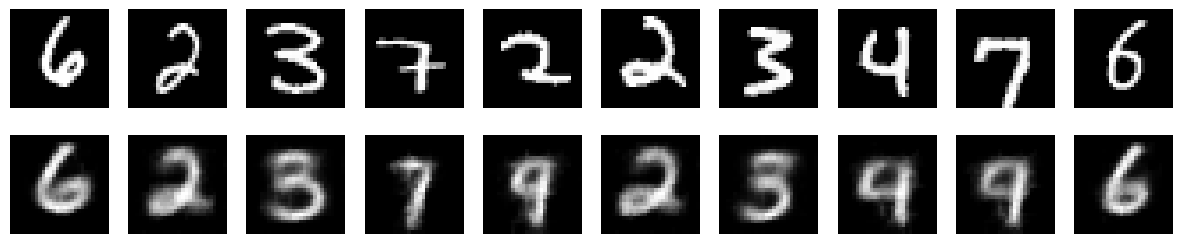

In [ ]:
# Plotting
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(images[i].squeeze(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(recon_images[i].squeeze(), cmap="gray")
    axes[1, i].axis("off")
plt.show()

In [ ]:
# Encode all test images and visualize in scatter plot
model.eval()
latents = []
labels = []
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        z = model.encoder(data)
        latents.append(z.cpu())
        labels.extend(target.numpy())

latents = torch.cat(latents).numpy()
labels = np.array(labels)

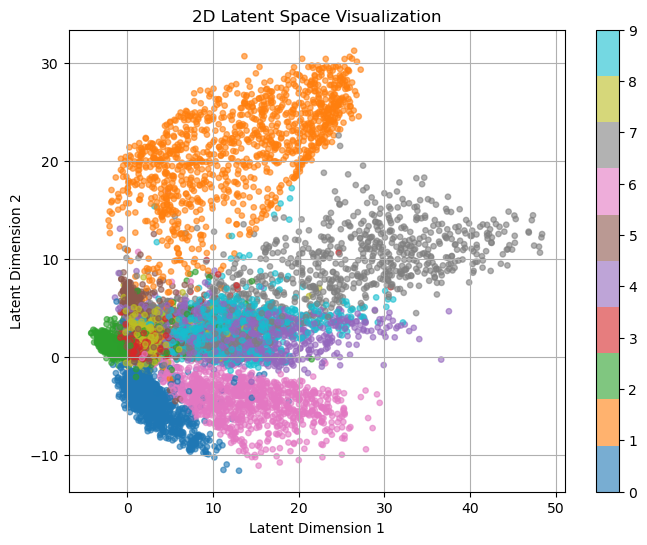

In [ ]:
# Scatter plot of 2D latent embeddings
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    latents[:, 0], latents[:, 1], c=labels, cmap="tab10", alpha=0.6, s=15
)
plt.colorbar(scatter, ticks=range(10))
plt.grid(False)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space Visualization")
plt.show()

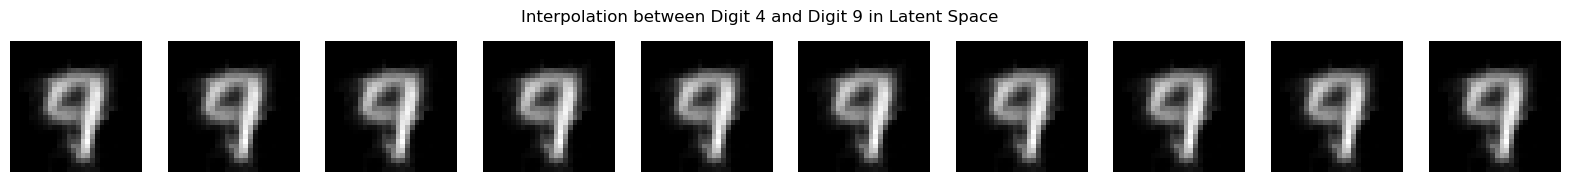

In [ ]:
# Interpolation between digits 4 and 9 in latent space

# Extract latent codes and labels of digits 4 and 9
latents_4 = latents[labels == 4]
latents_9 = latents[labels == 9]
indices_4 = np.where(labels == 4)[0]
indices_9 = np.where(labels == 9)[0]

# Find the pair of samples (one from each digit) that are closest in latent space
# Compute pairwise distances between latent codes of 4s and 9s
distances = cdist(latents_4, latents_9, "euclidean")
min_idx = np.unravel_index(distances.argmin(), distances.shape)

# Get the indices of the closest pair
idx_4 = indices_4[min_idx[0]]
idx_9 = indices_9[min_idx[1]]

# Retrieve the images and their latent codes
image_4, _ = test_dataset[idx_4]
image_9, _ = test_dataset[idx_9]

image_4 = image_4.to(device).unsqueeze(0)
image_9 = image_9.to(device).unsqueeze(0)

with torch.no_grad():
    z_4 = model.encoder(image_4).cpu()
    z_9 = model.encoder(image_9).cpu()

# Interpolate between z_4 and z_9
num_steps = 10
alphas = np.linspace(0, 1, num_steps)
interpolated_z = [(1 - alpha) * z_4 + alpha * z_9 for alpha in alphas]
interpolated_z = torch.stack(interpolated_z).squeeze(1).to(device)

# Decode the interpolated codes
with torch.no_grad():
    interpolated_images = model.decoder(interpolated_z).cpu()

# Plot the interpolated images
fig, axes = plt.subplots(1, num_steps, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.suptitle("Interpolation between Digit 4 and Digit 9 in Latent Space")
plt.show()



**Explanation:**

1. **Extract latent codes and labels for digits 4 and 9:**
   - We use the `latents` and `labels` arrays obtained from encoding all test images.
   - `latents_4` and `latents_9` contain the latent codes for all instances of digits 4 and 9, respectively.
   - `indices_4` and `indices_9` store the indices of these digits in the test dataset.

2. **Find the closest pair in latent space:**
   - We compute the pairwise Euclidean distances between the latent codes of digit 4 images and digit 9 images using `scipy.spatial.distance.cdist`.
   - The indices of the minimum distance in the distance matrix `distances` correspond to the closest pair.
   - `idx_4` and `idx_9` correspond to the indices in `test_dataset` of the closest digit 4 and digit 9 images in latent space.

3. **Retrieve the images and their latent codes:**
   - We load the images from `test_dataset` using the indices `idx_4` and `idx_9`.
   - We move the images to the device and add a batch dimension using `unsqueeze(0)`.
   - We encode the images to get their latent codes `z_4` and `z_9`.

4. **Perform linear interpolation in latent space:**
   - We define `num_steps`, the number of interpolation steps.
   - We create an array `alphas` that linearly spaces values between 0 and 1.
   - For each alpha, we compute the interpolated latent code: `z = (1 - alpha) * z_4 + alpha * z_9`.
   - We stack the interpolated codes into a tensor and move it to the device.

5. **Decode the interpolated latent codes:**
   - We pass the interpolated latent codes through the decoder to obtain the reconstructed images.
   - The output `interpolated_images` is a tensor containing the images corresponding to each interpolated latent code.

6. **Visualize the results:**
   - We plot the decoded interpolated images using `matplotlib`.
   - Each image shows the gradual transformation from digit 4 to digit 9.
   - The images are displayed without axes for clarity.

**Note:**
- Ensure that the variables `latents`, `labels`, `model`, `test_dataset`, and `device` are available in your environment before running this code.
- This code appends to the previous code and reuses computed variables, so it should be executed after completing the earlier steps, including training the autoencoder and obtaining the latent codes.

**Dependencies:**
- The code relies on `numpy`, `torch`, `matplotlib`, and `scipy` for computations and plotting.
- If `scipy` is not imported yet, you may need to add `from scipy.spatial.distance import cdist` at the top of your script.

**Example Output:**

The resulting plot will show a sequence of images that smoothly morph from a digit 4 to a digit 9, illustrating how the autoencoder's latent space captures the gradual transformation between these two digits.